## **Differential Transformer**
This is a lightweight (Differential nanoGPT) implementation of the newly proposed "Differential Tranformer". You can find offical implementation here: https://github.com/microsoft/unilm/tree/master/Diff-Transformer


<img src="assets/dtm.png"/>
<img src="assets/intro.png"/>


Streaming output truncated to the last 5000 lines.
iter 45051: loss 1.4397, time 9.76ms, mfu 0.49%
iter 45052: loss 1.4657, time 9.47ms, mfu 0.51%
iter 45053: loss 1.5523, time 9.30ms, mfu 0.52%
iter 45054: loss 1.5854, time 9.46ms, mfu 0.51%
iter 45055: loss 1.4762, time 9.33ms, mfu 0.52%
iter 45056: loss 1.4950, time 9.29ms, mfu 0.52%
iter 45057: loss 1.5420, time 9.42ms, mfu 0.51%
iter 45058: loss 1.4430, time 10.23ms, mfu 0.47%
iter 45059: loss 1.4006, time 9.75ms, mfu 0.49%
iter 45060: loss 1.5294, time 9.42ms, mfu 0.51%
iter 45061: loss 1.4692, time 9.44ms, mfu 0.51%
iter 45062: loss 1.4937, time 9.67ms, mfu 0.50%
iter 45063: loss 1.4826, time 9.21ms, mfu 0.52%
iter 45064: loss 1.3480, time 9.20ms, mfu 0.52%
iter 45065: loss 1.3764, time 9.34ms, mfu 0.52%
iter 45066: loss 1.5065, time 15.16ms, mfu 0.32%
iter 45067: loss 1.4512, time 9.37ms, mfu 0.51%
iter 45068: loss 1.4891, time 9.32ms, mfu 0.52%
iter 45069: loss 1.5007, time 9.51ms, mfu 0.51%
iter 45070: loss 1.5254, time 12.73

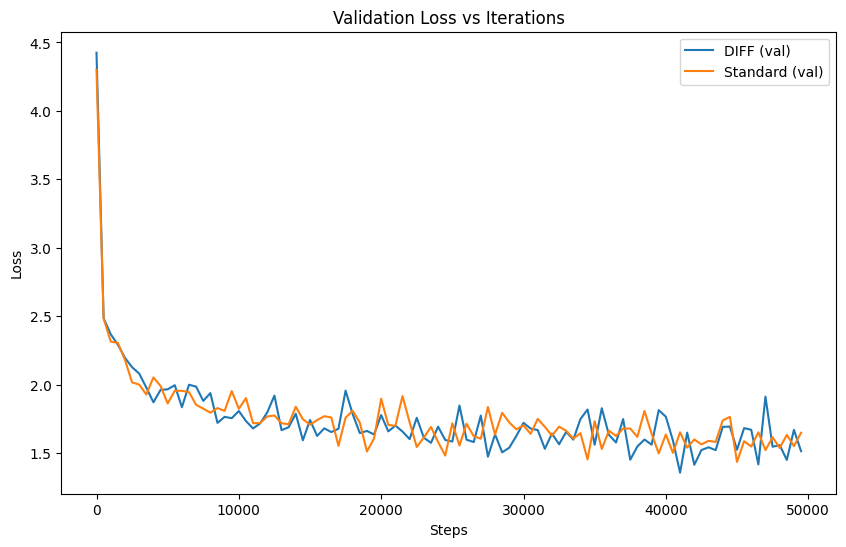

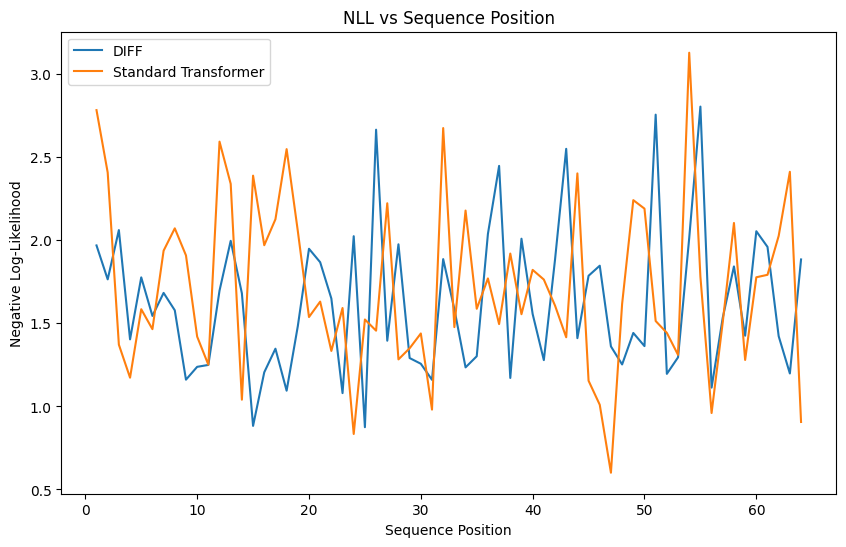

In [2]:
import os
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 12
block_size = 64
max_iters = 50000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 1
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.2

# Load and preprocess data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i + block_size] for i in ix])
    y = torch.stack([data_split[i + 1:i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)


def lambda_init(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * (depth - 1))


# Multi-head Differential Attention
class MultiHeadDiffAttention(nn.Module):
    def __init__(self, n_embd, n_head, layer_idx):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.lambda_init = lambda_init(layer_idx) 

        # split qkv
        self.q1_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.q2_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.k1_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.k2_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.v_proj = nn.Linear(n_embd, 2 * n_embd, bias=False)  # V projects to 2 * n_embd

        self.c_proj = nn.Linear(2 * n_embd, n_embd, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.subln = nn.LayerNorm(2 * self.head_size, elementwise_affine=False)

        # Init λ across heads
        self.lambda_q1 = nn.Parameter(torch.randn(n_head, self.head_size) * 0.1)
        self.lambda_k1 = nn.Parameter(torch.randn(n_head, self.head_size) * 0.1)
        self.lambda_q2 = nn.Parameter(torch.randn(n_head, self.head_size) * 0.1)
        self.lambda_k2 = nn.Parameter(torch.randn(n_head, self.head_size) * 0.1)

    def forward(self, x):
        B, T, C = x.shape

        # Project x to get q1, q2, k1, k2, v
        q1 = self.q1_proj(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        q2 = self.q2_proj(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k1 = self.k1_proj(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k2 = self.k2_proj(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_head, 2 * self.head_size).transpose(1, 2)

        scale = 1.0 / math.sqrt(self.head_size)
        att1 = torch.matmul(q1, k1.transpose(-2, -1)) * scale
        att2 = torch.matmul(q2, k2.transpose(-2, -1)) * scale

        attn_mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        att1 = att1.masked_fill(attn_mask == 0, float('-inf'))
        att2 = att2.masked_fill(attn_mask == 0, float('-inf'))

        att1 = F.softmax(att1, dim=-1)
        att2 = F.softmax(att2, dim=-1)

        # Compute λ for each head separately
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1)).unsqueeze(-1).unsqueeze(-1)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1)).unsqueeze(-1).unsqueeze(-1)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        att = att1 - lambda_full * att2
        att = self.attn_dropout(att)

        y = torch.matmul(att, v)  # [B, n_head, T, 2 * head_size]
        y = self.subln(y)
        y = y * (1 - self.lambda_init)

        y = y.transpose(1, 2).contiguous().view(B, T, 2 * C)
        y = self.resid_dropout(self.c_proj(y))
        return y


# Traditional Multi-head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head, layer_idx=None):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        attn_mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        att = att.masked_fill(attn_mask == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


# MLP
class MLP(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.c_proj = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = F.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


# Transformer Block
class Block(nn.Module):
    def __init__(self, n_embd, n_head, attention_class, layer_idx):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = attention_class(n_embd, n_head, layer_idx)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# Transformer Model
class nanoGPT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, attention_class):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(vocab_size, n_embd),
            wpe=nn.Embedding(block_size, n_embd),
            drop=nn.Dropout(dropout),
            h=nn.ModuleList([Block(n_embd, n_head, attention_class, layer_idx=i + 1) for i in range(n_layer)]),
            ln_f=nn.LayerNorm(n_embd),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.n_layer = n_layer
        self.n_embd = n_embd

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# MFU
def compute_mfu(model, fwdbwd_per_iter, dt):
    N = sum(p.numel() for p in model.parameters())
    L, H, Q, T = model.n_layer, model.n_embd, model.n_embd, model.block_size
    flops_per_token = 6 * N + 12 * L * H * T
    flops_per_fwdbwd = flops_per_token * T
    flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
    flops_achieved = flops_per_iter * (1.0 / dt)  # per second
    flops_promised = 7e12  # A100 GPU
    mfu = flops_achieved / flops_promised
    return mfu


# Train and eval
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


def train_model(model, model_type):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    losses = []
    val_losses = []

    t0 = time.time()
    for iter in range(max_iters):
        if iter % eval_interval == 0:
            loss_dict = estimate_loss(model)
            print(f"step {iter}: train loss {loss_dict['train']:.4f}, val loss {loss_dict['val']:.4f}")
            losses.append(loss_dict['train'])
            val_losses.append(loss_dict['val'])

        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % 1 == 0:
            t1 = time.time()
            dt = t1 - t0
            t0 = t1
            lossf = loss.item()
            mfu = compute_mfu(model, 1, dt)
            print(f"iter {iter}: loss {lossf:.4f}, time {dt * 1000:.2f}ms, mfu {mfu * 100:.2f}%")

    # Save checkpoint
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"{model_type}_model.pt"))

    return losses, val_losses


# Init models
diff_model = nanoGPT(
    vocab_size, n_embd, n_head, n_layer, block_size, MultiHeadDiffAttention
).to(device)
standard_model = nanoGPT(
    vocab_size, n_embd, n_head, n_layer, block_size, MultiHeadAttention
).to(device)

# Train
print("Training With DIFF Transformer")
diff_losses, diff_val_losses = train_model(diff_model, "DIFF")

print("\nTraining With Standard Transformer")
standard_losses, standard_val_losses = train_model(standard_model, "Standard")

# Sample
def sample(model, model_type):
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(f"-----------------------------------------")
    print(f"Sample from {model_type} Transformer")
    print(f"-----------------------------------------")
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


def plot_nll_vs_position():
    plt.figure(figsize=(10, 6))
    for model, model_type in [(diff_model, 'DIFF'), (standard_model, 'Standard Transformer')]:
        nll = []
        for pos in range(block_size):
            x, y = get_batch('val')
            with torch.no_grad():
                logits, _ = model(x)
                loss = F.cross_entropy(logits[:, pos, :], y[:, pos], reduction='mean')
            nll.append(loss.item())
        plt.plot(range(1, block_size + 1), nll, label=model_type)
    plt.xlabel('Sequence Position')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('NLL vs Sequence Position')
    plt.legend()
    plt.show()
    plt.close()


def plot_training_curves():
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, max_iters, eval_interval), diff_val_losses, label='DIFF (val)')
    plt.plot(range(0, max_iters, eval_interval), standard_val_losses, label='Standard (val)')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Validation Loss vs Iterations')
    plt.legend()
    plt.show()
    plt.close()


sample(diff_model, "DIFF")
sample(standard_model, "Standard")
plot_training_curves()
plot_nll_vs_position()
